# Task 3: Are Prompts a Stable Control Knob for DA/DG with CLIP?
- Part 3
---

### Installs:

In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torchvision

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-pn636ha8
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-pn636ha8
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install datasets

### Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import clip
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tqdm.notebook import tqdm
import torch.nn.functional as F

### Device:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### CLIP:

In [ ]:
model, preprocess = clip.load("ViT-B/32", device=device)

### Loading PACS:

In [ ]:
dataset = load_dataset("flwrlabs/pacs", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
photo_dataset = dataset.filter(lambda example: example["domain"] == "photo")
sketch_dataset = dataset.filter(lambda example: example["domain"] == "sketch")

In [ ]:
class PACSDataset(Dataset):
    def __init__(self, hf_dataset, transform):
        self.data = hf_dataset
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = self.data[idx]["image"]
        label = self.data[idx]["label"]
        image = self.transform(image)
        return {"image": image, "label": torch.tensor(label, dtype=torch.long)}

In [ ]:
source_dataset = PACSDataset(photo_dataset, preprocess)
target_dataset = PACSDataset(sketch_dataset, preprocess)
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)

## 3. Gradient Conflict and Alignment:

In [ ]:
for param in model.parameters():
    param.requires_grad = False
feature_dimension = model.visual.output_dim
num_classes = 7
classifier = nn.Linear(feature_dimension, num_classes).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
def get_gradients(dataloader, model, classifier, criterion, device, max_batches=1):
    model.eval()
    classifier.train()
    grads = []
    for i, batch in enumerate(dataloader):
        if i >= max_batches:
            break
        images, labels = batch["image"].to(device), batch["label"].to(device)
        with torch.no_grad():
            features = model.encode_image(images)
        features = features.float()
        logits = classifier(features)
        loss = criterion(logits, labels)
        classifier.zero_grad()
        loss.backward()
        grad_vector = torch.cat([p.grad.flatten() for p in classifier.parameters()]).detach()
        grads.append(grad_vector)
    return grads[0]

In [ ]:
num_of_epochs = 16
similarities = []
recorded_epochs = []
photo_iter = iter(source_dataloader)
sketch_iter = iter(target_dataloader)
for epoch in range(num_of_epochs):
    classifier.train()
    running_loss = 0.0
    num_batches = 0
    for i, (source_batch, target_batch) in enumerate(zip(source_dataloader, target_dataloader)):
        source_images, source_labels = source_batch["image"].to(device), source_batch["label"].to(device)
        target_images, target_labels = target_batch["image"].to(device), target_batch["label"].to(device)
        all_images = torch.cat([source_images, target_images], dim=0)
        all_labels = torch.cat([source_labels, target_labels], dim=0)
        with torch.no_grad():
            features = model.encode_image(all_images)
        features = features.float()
        logits = classifier(features)
        loss = criterion(logits, all_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num_batches += 1
    avg_loss = running_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss}")
    if (epoch + 1) % 2 == 0:
        source_grads = get_gradients(source_dataloader, model, classifier, criterion, device)
        target_grads = get_gradients(target_dataloader, model, classifier, criterion, device)
        cosine_similarity = F.cosine_similarity(source_grads, target_grads, dim=0).item()
        similarities.append(cosine_similarity)
        recorded_epochs.append(epoch)
        print(f"Epoch {epoch+1}: Gradient cosine similarity = {cosine_similarity:.4f}")

Epoch 1 completed. Average Loss: 1.0384933166908767
Epoch 2 completed. Average Loss: 0.3625697440133904
Epoch 2: Gradient cosine similarity = -0.0338
Epoch 3 completed. Average Loss: 0.24745562756961248
Epoch 4 completed. Average Loss: 0.1983921747162657
Epoch 4: Gradient cosine similarity = -0.2633
Epoch 5 completed. Average Loss: 0.1700558526054868
Epoch 6 completed. Average Loss: 0.15298580308005494
Epoch 6: Gradient cosine similarity = 0.0099
Epoch 7 completed. Average Loss: 0.1466436079650555
Epoch 8 completed. Average Loss: 0.12636168729865327
Epoch 8: Gradient cosine similarity = -0.1119
Epoch 9 completed. Average Loss: 0.13114410807501595
Epoch 10 completed. Average Loss: 0.12154587997861628
Epoch 10: Gradient cosine similarity = 0.5451
Epoch 11 completed. Average Loss: 0.1217154878068645
Epoch 12 completed. Average Loss: 0.1208853137521249
Epoch 12: Gradient cosine similarity = 0.2631
Epoch 13 completed. Average Loss: 0.11865905658254083
Epoch 14 completed. Average Loss: 0.102

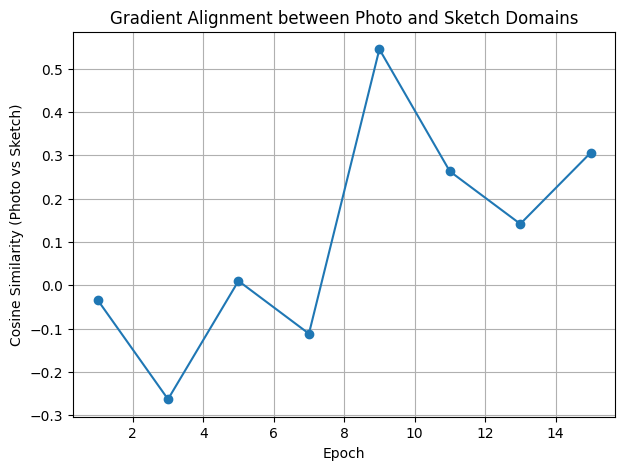

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(recorded_epochs, similarities, marker='o')
plt.title("Gradient Alignment between Photo and Sketch Domains")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity (Photo vs Sketch)")
plt.grid(True)
plt.show()